# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Bixo Fredik"
student2 = "Mbanga Ndjock Pierre Armel"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import keras

Using TensorFlow backend.


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

### Plotting

In [4]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [109]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

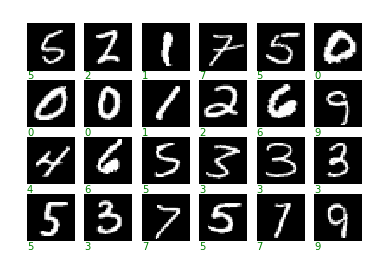

In [111]:
# Plot the digits
res = plot_some_samples(x_train, (y_train+9)%10)

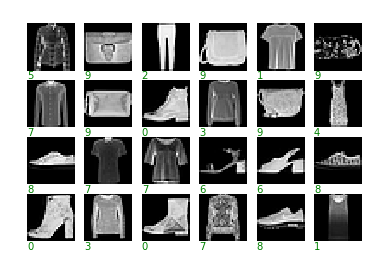

In [112]:
res = plot_some_samples(x_fashion_train, (y_fashion_train))

Answer to question 2: The green digits at the bottom left of each image indicate the labels associated to the image in the dataset !

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [8]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [9]:
from keras.callbacks import EarlyStopping

In [10]:
# For more accurate estimates of the SGD
batch_size = 128
# Number of epochs for the training
n_epochs = 10000
# Number of classes
num_classes = 10
# define the patience for EarlyStopping
patience = 10

model = Sequential()

# Use the softmax activation for the output layer
model.add(Dense(num_classes, activation='softmax'))

# Fine tune the optimizer
sgd = SGD(lr=0.1)

model.compile(loss='categorical_crossentropy', # Use the categorical_crossentropy loss
              optimizer=sgd, # Use stochastic gradient descent for the optimizer
              metrics=['accuracy']) # Add the accuracy metric to the metrics


# Define Early Stopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size, # choose a minibatch of size 128
                    epochs=n_epochs, # Fit for as many epochs as needed to see no further decrease in the validation loss ??
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[es])

model.summary()

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10000
60000/60000 [==============================] - 1s 11us/step - loss: 0.5825 - acc: 0.8531 - val_loss: 0.3828 - val_acc: 0.8975
Epoch 2/10000
60000/60000 [==============================] - 1s 10us/step - loss: 0.3759 - acc: 0.8967 - val_loss: 0.3384 - val_acc: 0.9064
Epoch 3/10000
60000/60000 [==============================] - 1s 11us/step - loss: 0.3437 - acc: 0.9045 - val_loss: 0.3165 - val_acc: 0.9129
Epoch 4/10000
60000/60000 [==============================] - 1s 11us/step - loss: 0.3270 - acc: 0.9085 - val_loss: 0.3062 - val_acc: 0.9161
Epoch 5/10000
60000/60000 [==============================] - 1s 12us/step - loss: 0.3162 - acc: 0.9124 - val_loss: 0.2995 - val_acc: 0.9163
Epoch 6/10000
60000/60000 [==============================] - 1s 12us/step - loss: 0.3083 - acc: 0.9139 - val_loss: 0.2968 - val_ac

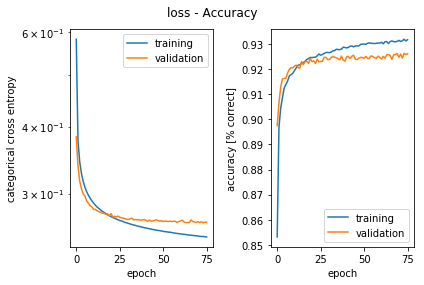

In [11]:
plot_1 = plot_history(history, title='loss - Accuracy')

Answer to question 10:

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [9]:
import pickle
from pathlib import Path
from os.path import join

In [10]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [11]:
def save(save_path, histories, summaries, scores):
    ok = True
    try:
        # Save Histories
        with open(join(save_path, Path('histories.pkl')), "wb") as f:
            pickle.dump(histories, f)
        # Save Summaries
        with open(join(save_path, Path('summaries.pkl')), "wb") as f:
            pickle.dump(summaries, f)
        # Save Scores
        with open(join(save_path, Path('scores.pkl')), "wb") as f:
            pickle.dump(scores, f)
    except Exception as e:
        print(e)
        ok = False
    return ok

In [16]:
def load(load_path):
    histories, summaries, scores = None, None, None
    try:
        # Load histories
        histories = pickle.load(open(join(load_path, Path('histories.pkl')), "rb" ))
        # Load summaries
        summaries = pickle.load(open(join(load_path, Path('summaries.pkl')), "rb" ))
        # Load summaries
        scores = pickle.load(open(join(load_path, Path('scores.pkl')), "rb" ))
    except Exception as e:
          print(e)
    
    return histories, summaries, scores

In [15]:
# dropout in the hidden layers with weight constraint
def create_model_exercice3(lr, optimizer, num_hidden_units=128, input_dim=784, num_classes=10):
    # Create model
    model = Sequential()
    model.add(Dense(num_hidden_units, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=optimizer, 
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [16]:
# choose a minibatch of size 128
batch_size = 128
# Use one hidden layer with 128 units
num_hidden_units = 128
# Size of input
input_dim = len(x_train[0])
# Fit the model for 50 epochs
epochs = 50
# Percentage of the training set dedicated to validation
validation_split = 0.2

# Define different learning rates
lrs = [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1] 
# Define optimization strategies
optimizers = [SGD(), Adam()] 
# datasets
datasets = [('MNIST', x_train, x_test, y_train, y_test), 
            ('Fashion-MNIST', x_fashion_train, x_fashion_test, y_fashion_train, y_fashion_test)] 

# save histories, summaries and scores
histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    # Learn with various parameters
    for lr in lrs:
        # Define level one keys
        key_lr = 'lr={}'.format(str(lr))
        histories[name][key_lr], summaries[name][key_lr], scores[name][key_lr] = {}, {}, {}

        for optim in optimizers:
            # Set learning rate
            optim = optim.from_config({'lr':lr})
            # Get model
            model = create_model_exercice3(lr, optim)
            # Fit model
            history = model.fit(input_train, target_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=0,
                                validation_data=(input_test, target_test))

            # Get optimizer name
            key_optim = optim.__class__.__name__
            # Update dictionnaries
            histories[name][key_lr][key_optim] = history
            summaries[name][key_lr][key_optim] = model.summary
            # Update scores
            test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
            scores[name][key_lr][key_optim] = {}
            scores[name][key_lr][key_optim]['test_loss'] = test_loss
            scores[name][key_lr][key_optim]['test_acc'] = test_acc

In [17]:
# Save path
save_path = Path('./save/exercice3/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [13]:
# Load path
load_path = Path('./save/exercice3/')
# Load histories
histories_3 , summaries_3, scores_3 = load(load_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


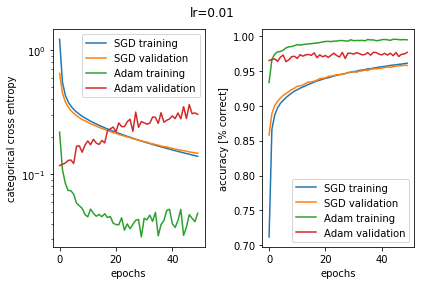

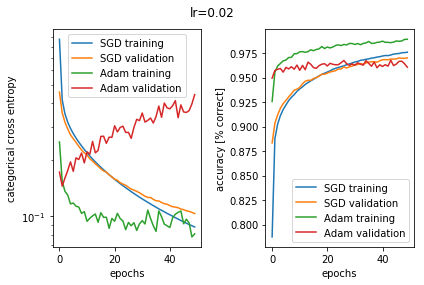

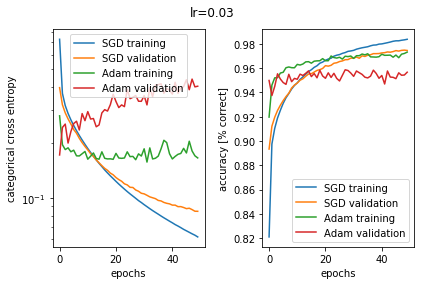

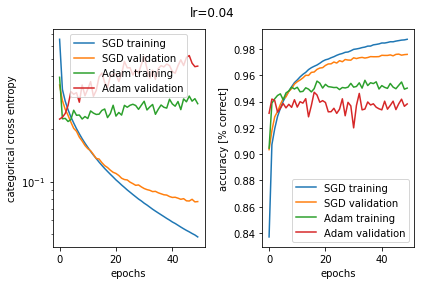

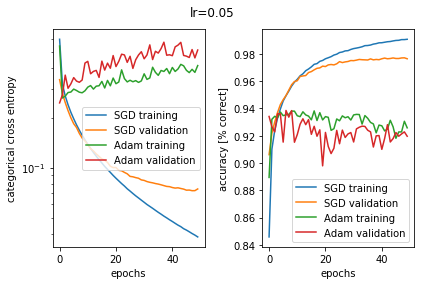

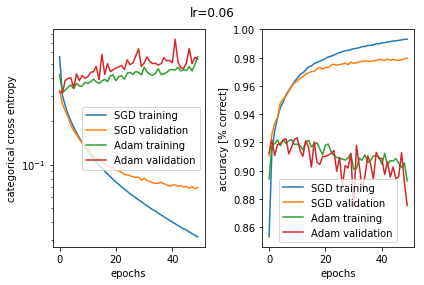

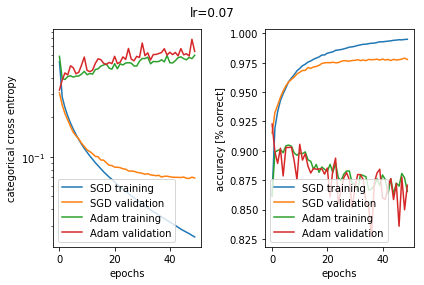

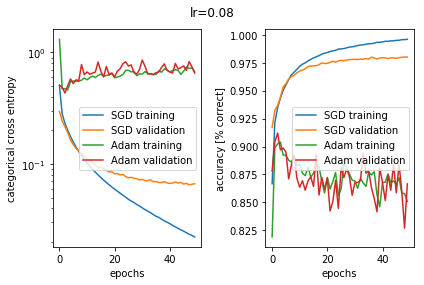

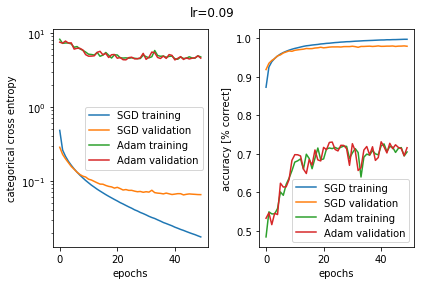

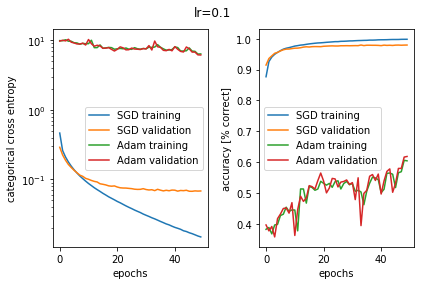

In [18]:
# Plot the learning curves of SGD together with the learning curves of Adam in the same figure
mnist, sgd, adam = 'MNIST', 'SGD', 'Adam'
for lr in histories_3[mnist]:
    # Plot histories
    comparison_plot(histories_3[mnist][lr][sgd], histories_3[mnist][lr][adam], sgd, adam, lr)        

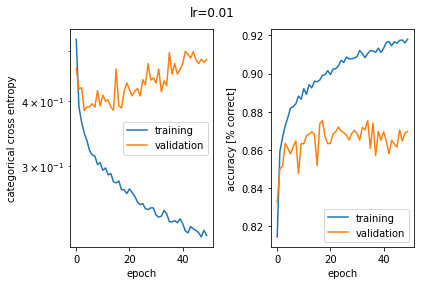

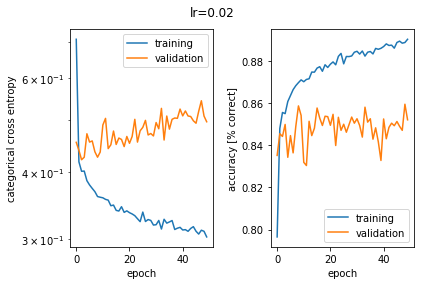

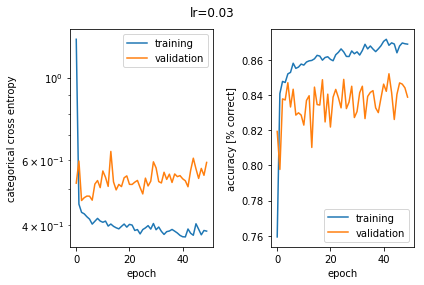

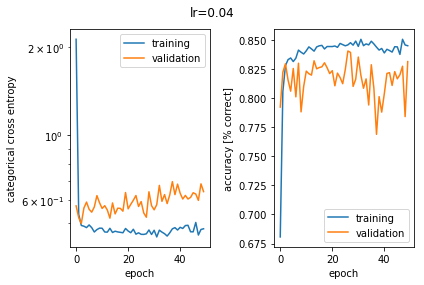

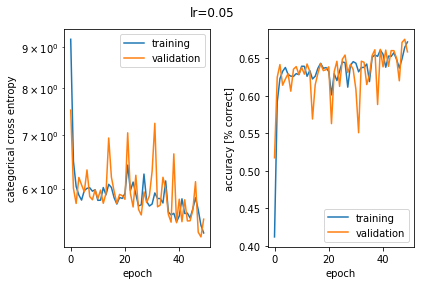

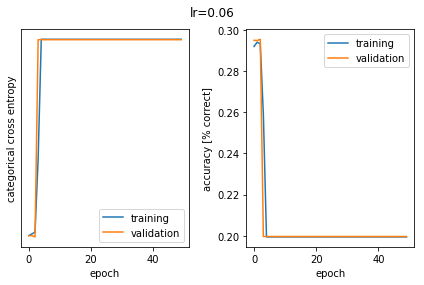

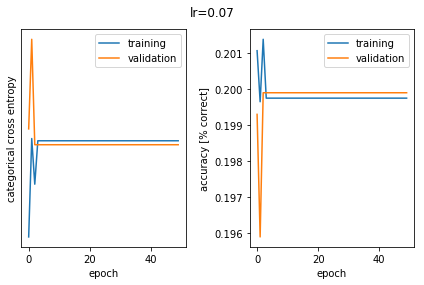

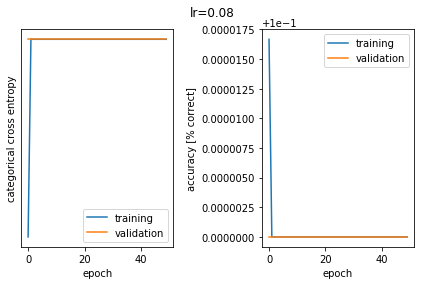

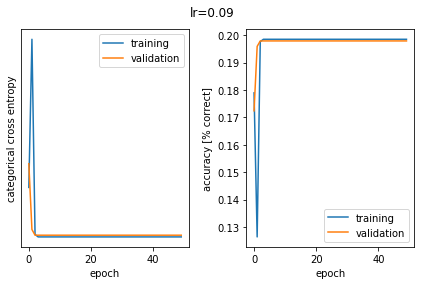

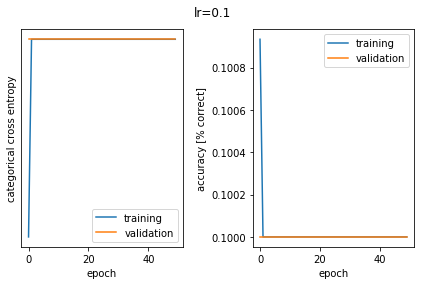

In [20]:
# Plot the learning curves on Fashion-Mnist using Adam optimizer 
fashion, adam = 'Fashion-MNIST', 'Adam'
for lr in histories_3[fashion]:
    plot_history(histories_3[fashion][lr][adam], lr)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A)

B)

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**:

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [18]:
def create_model_exercice4(num_hidden_units, lr=0.01, input_dim=784, num_classes=10):
    # Create model
    model = Sequential()
    model.add(Dense(num_hidden_units, activation='relu', input_dim=input_dim)) # Use the relu activation for the hidden layer
    model.add(Dense(num_classes, activation='softmax')) # Use the softmax activation for the output layer
    
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=Adam(lr=lr), # You may use the Adam optimizer
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [26]:
def prepare_best_metrics_plot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_best_metrics_plot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_best_metrics(ys, xs, title):
    fig, ax1, ax2 = prepare_best_metrics_plot(title, 'hidden units')
    ax1.plot(xs, ys['MNIST']['best_val_loss'], label = "MNIST")
    ax1.plot(xs, ys['Fashion-MNIST']['best_val_loss'], label = "Fashion-MNIST")
    ax2.plot(xs, ys['MNIST']['best_val_acc'], label = "MNIST")
    ax2.plot(xs, ys['Fashion-MNIST']['best_val_acc'], label = "Fashion-MNIST")
    finalize_best_metrics_plot(fig, ax1, ax2)
    return fig

In [20]:
# For more accurate estimates of the SGD
batch_size = 128
# define the patience for EarlyStopping
patience = 10
# Define Early Stopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# Sufficiently large for earlyStopping to occur
epochs = 100000000

# hidden units 
num_hidden_units = [32, 64, 128, 512, 1024]
# datasets
datasets = [('MNIST', x_train, x_test, y_train, y_test), 
            ('Fashion-MNIST', x_fashion_train, x_fashion_test, y_fashion_train, y_fashion_test)]

# save histories, summaries and scores
histories, summaries, scores = {}, {}, {}

for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    
    for num in num_hidden_units:
        # Get model
        model = create_model_exercice4(num)    
        # Train the model
        history = model.fit(input_train, target_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(input_test, target_test),
                            callbacks=[es])


        # Update histories and summaries
        key_hu = 'num_hidden_units={}'.format(str(num))
        histories[name][key_hu], summaries[name][key_hu] = history, model.summary      
        # Update scores
        test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
        scores[name][key_hu] = {}
        scores[name][key_hu]['test_loss'] = test_loss
        scores[name][key_hu]['test_acc'] = test_acc

Train on 60000 samples, validate on 10000 samples
Epoch 1/100000000
60000/60000 [==============================] - 2s 32us/step - loss: 0.2889 - acc: 0.9162 - val_loss: 0.2044 - val_acc: 0.9406
Epoch 2/100000000
60000/60000 [==============================] - 1s 15us/step - loss: 0.1704 - acc: 0.9504 - val_loss: 0.1767 - val_acc: 0.9484
Epoch 3/100000000
60000/60000 [==============================] - 1s 15us/step - loss: 0.1427 - acc: 0.9577 - val_loss: 0.1614 - val_acc: 0.9528
Epoch 4/100000000
60000/60000 [==============================] - 1s 15us/step - loss: 0.1280 - acc: 0.9613 - val_loss: 0.1455 - val_acc: 0.9578
Epoch 5/100000000
60000/60000 [==============================] - 1s 15us/step - loss: 0.1170 - acc: 0.9651 - val_loss: 0.1514 - val_acc: 0.9575
Epoch 6/100000000
60000/60000 [==============================] - 1s 16us/step - loss: 0.1070 - acc: 0.9674 - val_loss: 0.1565 - val_acc: 0.9579
Epoch 7/100000000
60000/60000 [==============================] - 1s 15us/step - loss: 

Epoch 12/100000000
60000/60000 [==============================] - 3s 47us/step - loss: 0.0544 - acc: 0.9873 - val_loss: 0.1707 - val_acc: 0.9744
Epoch 13/100000000
60000/60000 [==============================] - 3s 47us/step - loss: 0.0467 - acc: 0.9895 - val_loss: 0.1879 - val_acc: 0.9714
Epoch 00013: early stopping
Train on 60000 samples, validate on 10000 samples
Epoch 1/100000000
60000/60000 [==============================] - 6s 99us/step - loss: 0.2161 - acc: 0.9372 - val_loss: 0.1110 - val_acc: 0.9659
Epoch 2/100000000
60000/60000 [==============================] - 5s 80us/step - loss: 0.1147 - acc: 0.9659 - val_loss: 0.1239 - val_acc: 0.9661
Epoch 3/100000000
60000/60000 [==============================] - 5s 81us/step - loss: 0.0951 - acc: 0.9723 - val_loss: 0.1289 - val_acc: 0.9676
Epoch 4/100000000
60000/60000 [==============================] - 5s 80us/step - loss: 0.0770 - acc: 0.9779 - val_loss: 0.1133 - val_acc: 0.9745
Epoch 5/100000000
60000/60000 [=========================

In [21]:
# Save path
save_path = Path('./save/exercice4/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [21]:
# Load path
load_path = Path('./save/exercice4/')
# Load histories
histories_4 , summaries_4, scores_4 = load(load_path)

In [27]:
# Plot the best validation loss and accuracy versus the number of hidden neurons
ys = {}
for name in histories_4:
    ys[name] = {}
    
    best_val_acc, best_val_loss = [], []
    for key_num_hidden_units in histories_4[name]:
        # Get best validation accuracy
        acc = min(histories_4[name][key_num_hidden_units].history['val_acc'])
        # Get best validation loss
        loss = min(histories_4[name][key_num_hidden_units].history['val_loss'])
        # Append result
        best_val_acc.append(acc), best_val_loss.append(loss)
        
    ys[name]['best_val_acc'], ys[name]['best_val_loss'] = best_val_acc, best_val_loss
    
xs = [32, 64, 128, 512, 1024]

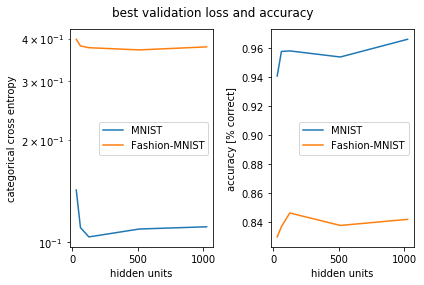

In [28]:
a = plot_best_metrics(ys, xs, 'best validation loss and accuracy')

Answer to question 2:

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [38]:
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l1, l2

from distutils.util import strtobool

In [48]:
def create_model_exercice5(num_hidden_units=50, lr=0.01, input_dim=784, num_classes=10,
                           regularizer=None, batch_norm=False, dropout=False):
    # Create model
    model = Sequential()
    
    # Hidden Layer
    if regularizer is None:
        model.add(Dense(num_hidden_units, activation='linear', input_dim=input_dim))
    else:
        model.add(Dense(num_hidden_units, activation='linear', kernel_regularizer=regularizer, 
                        bias_regularizer=regularizer, input_dim=input_dim))
    model.add(Activation('relu'))
    # Batch normalization
    if batch_norm:
        model.add(BatchNormalization())
    # Dropout    
    if dropout:
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy, # Use the categorical_crossentropy loss
                      optimizer=Adam(lr=lr), # You may use the Adam optimizer
                      metrics=['accuracy']) # Add the accuracy metric to the metrics
    return model

In [50]:
batch_size = 128
epochs = 100

# Define different regularizers
my_regularizers = {'L0': None, 'L1': l1(0.01), 'L2': l2(0.01)}
# Use batch normalization ?
batch_norm = [False, True] 
# Use dropout ?
dropout = [False, True]

In [24]:
# save histories, summaries, and scores
histories, summaries, scores = {}, {}, {}
# Learn with various parameters
for reg_type in my_regularizers:
    # Create regularization entry
    histories[reg_type], summaries[reg_type], scores[reg_type] = {}, {}, {}
    for with_batch_norm in batch_norm:
        # Create batch_norm entry
        key_bn = 'batch_norm={}'.format(str(with_batch_norm))
        histories[reg_type][key_bn], summaries[reg_type][key_bn], scores[reg_type][key_bn] = {}, {}, {}
        for with_dropout in dropout:
            # Get model
            model = create_model_exercice5(regularizer=my_regularizers[reg_type], batch_norm=with_batch_norm, dropout=with_dropout)
            # Fit model
            history = model.fit(x_fashion_train, y_fashion_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_fashion_test, y_fashion_test))

            # Add history an summary values
            key_dp = 'dropout={}'.format(str(with_dropout))
            histories[reg_type][key_bn][key_dp], summaries[reg_type][key_bn][key_dp] = history, model.summary
            # Save scores
            test_loss, test_acc = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
            scores[reg_type][key_bn][key_dp] = {}
            scores[reg_type][key_bn][key_dp]['test_loss'] = test_loss
            scores[reg_type][key_bn][key_dp]['test_acc'] = test_acc

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.5284 - acc: 0.8132 - val_loss: 0.4313 - val_acc: 0.8494
Epoch 2/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.4006 - acc: 0.8572 - val_loss: 0.4319 - val_acc: 0.8447
Epoch 3/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3799 - acc: 0.8646 - val_loss: 0.4173 - val_acc: 0.8470
Epoch 4/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3626 - acc: 0.8690 - val_loss: 0.4062 - val_acc: 0.8487
Epoch 5/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3517 - acc: 0.8715 - val_loss: 0.4100 - val_acc: 0.8504
Epoch 6/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3418 - acc: 0.8745 - val_loss: 0.4344 - val_acc: 0.8529
Epoch 7/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3361 - acc: 0.8753 - val_loss: 0.3995 - 

60000/60000 [==============================] - 1s 20us/step - loss: 0.4079 - acc: 0.8480 - val_loss: 0.4244 - val_acc: 0.8539
Epoch 16/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4034 - acc: 0.8498 - val_loss: 0.4025 - val_acc: 0.8579
Epoch 17/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3970 - acc: 0.8507 - val_loss: 0.4268 - val_acc: 0.8536
Epoch 18/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3917 - acc: 0.8535 - val_loss: 0.4368 - val_acc: 0.8511
Epoch 19/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3955 - acc: 0.8510 - val_loss: 0.4245 - val_acc: 0.8527
Epoch 20/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3902 - acc: 0.8541 - val_loss: 0.4060 - val_acc: 0.8651
Epoch 21/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3879 - acc: 0.8544 - val_loss: 0.4114 - val_acc: 0.8605
Epoch 22/100
60000/60000 [==============

60000/60000 [==============================] - 1s 20us/step - loss: 0.3488 - acc: 0.8679 - val_loss: 0.4650 - val_acc: 0.8617
Epoch 75/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3460 - acc: 0.8679 - val_loss: 0.4478 - val_acc: 0.8611
Epoch 76/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3441 - acc: 0.8685 - val_loss: 0.4723 - val_acc: 0.8540
Epoch 77/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3441 - acc: 0.8694 - val_loss: 0.4586 - val_acc: 0.8579
Epoch 78/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3465 - acc: 0.8674 - val_loss: 0.4778 - val_acc: 0.8413
Epoch 79/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3431 - acc: 0.8687 - val_loss: 0.5082 - val_acc: 0.8521
Epoch 80/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3459 - acc: 0.8682 - val_loss: 0.4755 - val_acc: 0.8463
Epoch 81/100
60000/60000 [==============

Epoch 33/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2275 - acc: 0.9137 - val_loss: 0.4412 - val_acc: 0.8548
Epoch 34/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2260 - acc: 0.9145 - val_loss: 0.4156 - val_acc: 0.8701
Epoch 35/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2234 - acc: 0.9165 - val_loss: 0.4200 - val_acc: 0.8625
Epoch 36/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2211 - acc: 0.9172 - val_loss: 0.4153 - val_acc: 0.8654
Epoch 37/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2192 - acc: 0.9180 - val_loss: 0.3993 - val_acc: 0.8699
Epoch 38/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2159 - acc: 0.9196 - val_loss: 0.4224 - val_acc: 0.8661
Epoch 39/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2167 - acc: 0.9180 - val_loss: 0.4424 - val_acc: 0.8630
Epoch 40/100
60000/60000 [=

Epoch 92/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1698 - acc: 0.9374 - val_loss: 0.5204 - val_acc: 0.8613
Epoch 93/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1717 - acc: 0.9356 - val_loss: 0.5144 - val_acc: 0.8593
Epoch 94/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1714 - acc: 0.9359 - val_loss: 0.4767 - val_acc: 0.8703
Epoch 95/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1674 - acc: 0.9379 - val_loss: 0.4955 - val_acc: 0.8616
Epoch 96/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1701 - acc: 0.9366 - val_loss: 0.5099 - val_acc: 0.8604
Epoch 97/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1696 - acc: 0.9365 - val_loss: 0.5395 - val_acc: 0.8616
Epoch 98/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1674 - acc: 0.9366 - val_loss: 0.5220 - val_acc: 0.8571
Epoch 99/100
60000/60000 [=

Epoch 9/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5480 - acc: 0.7487 - val_loss: 1.4508 - val_acc: 0.7554
Epoch 10/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5503 - acc: 0.7486 - val_loss: 1.4910 - val_acc: 0.7450
Epoch 11/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5357 - acc: 0.7482 - val_loss: 1.5160 - val_acc: 0.7632
Epoch 12/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5547 - acc: 0.7495 - val_loss: 2.1387 - val_acc: 0.6124
Epoch 13/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5753 - acc: 0.7472 - val_loss: 1.5170 - val_acc: 0.7518
Epoch 14/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5373 - acc: 0.7506 - val_loss: 1.4708 - val_acc: 0.7519
Epoch 15/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5814 - acc: 0.7500 - val_loss: 1.5167 - val_acc: 0.7322
Epoch 16/100
60000/60000 [==

Epoch 68/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5349 - acc: 0.7574 - val_loss: 1.6450 - val_acc: 0.7308
Epoch 69/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.6246 - acc: 0.7511 - val_loss: 1.5464 - val_acc: 0.7238
Epoch 70/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5711 - acc: 0.7533 - val_loss: 2.2959 - val_acc: 0.7151
Epoch 71/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.6655 - acc: 0.7501 - val_loss: 1.4510 - val_acc: 0.7619
Epoch 72/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5962 - acc: 0.7510 - val_loss: 1.6027 - val_acc: 0.7632
Epoch 73/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5365 - acc: 0.7561 - val_loss: 1.5612 - val_acc: 0.7345
Epoch 74/100
60000/60000 [==============================] - 1s 20us/step - loss: 1.5620 - acc: 0.7503 - val_loss: 1.5239 - val_acc: 0.7574
Epoch 75/100
60000/60000 [=

60000/60000 [==============================] - 1s 22us/step - loss: 2.0893 - acc: 0.6554 - val_loss: 1.9332 - val_acc: 0.6873
Epoch 86/100
60000/60000 [==============================] - 1s 22us/step - loss: 2.1524 - acc: 0.6480 - val_loss: 2.0356 - val_acc: 0.6838
Epoch 87/100
60000/60000 [==============================] - 1s 21us/step - loss: 2.1536 - acc: 0.6455 - val_loss: 1.9985 - val_acc: 0.6577
Epoch 88/100
60000/60000 [==============================] - 1s 22us/step - loss: 2.0927 - acc: 0.6535 - val_loss: 1.7604 - val_acc: 0.7340
Epoch 89/100
60000/60000 [==============================] - 1s 21us/step - loss: 2.1635 - acc: 0.6510 - val_loss: 1.9038 - val_acc: 0.7090
Epoch 90/100
60000/60000 [==============================] - 1s 22us/step - loss: 2.0634 - acc: 0.6525 - val_loss: 2.0850 - val_acc: 0.7005
Epoch 91/100
60000/60000 [==============================] - 1s 22us/step - loss: 2.1454 - acc: 0.6517 - val_loss: 2.2187 - val_acc: 0.6900
Epoch 92/100
60000/60000 [==============

Epoch 44/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.7414 - acc: 0.7690 - val_loss: 2.1360 - val_acc: 0.6095
Epoch 45/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.7711 - acc: 0.7673 - val_loss: 3.1813 - val_acc: 0.4800
Epoch 46/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.7603 - acc: 0.7676 - val_loss: 2.2916 - val_acc: 0.6207
Epoch 47/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.7608 - acc: 0.7680 - val_loss: 2.4251 - val_acc: 0.5738
Epoch 48/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.8200 - acc: 0.7674 - val_loss: 1.7854 - val_acc: 0.7546
Epoch 49/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.7546 - acc: 0.7703 - val_loss: 2.0886 - val_acc: 0.7039
Epoch 50/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.7934 - acc: 0.7679 - val_loss: 2.7215 - val_acc: 0.5754
Epoch 51/100
60000/60000 [=

60000/60000 [==============================] - 1s 24us/step - loss: 3.2327 - acc: 0.7002 - val_loss: 4.4543 - val_acc: 0.4730
Epoch 62/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.1999 - acc: 0.6997 - val_loss: 5.3186 - val_acc: 0.3636
Epoch 63/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.3852 - acc: 0.7027 - val_loss: 5.6775 - val_acc: 0.3404
Epoch 64/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.1924 - acc: 0.6994 - val_loss: 4.8014 - val_acc: 0.4249
Epoch 65/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.1804 - acc: 0.7037 - val_loss: 4.5239 - val_acc: 0.5228
Epoch 66/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.2784 - acc: 0.7050 - val_loss: 3.9203 - val_acc: 0.5022
Epoch 67/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.4443 - acc: 0.6966 - val_loss: 3.8109 - val_acc: 0.5783
Epoch 68/100
60000/60000 [==============

Epoch 20/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.6783 - acc: 0.8081 - val_loss: 0.6740 - val_acc: 0.8031
Epoch 21/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.6848 - acc: 0.8075 - val_loss: 0.7339 - val_acc: 0.7842
Epoch 22/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.7082 - acc: 0.8036 - val_loss: 0.7082 - val_acc: 0.7959
Epoch 23/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6742 - acc: 0.8078 - val_loss: 0.7477 - val_acc: 0.7809
Epoch 24/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6909 - acc: 0.8043 - val_loss: 0.7112 - val_acc: 0.7876
Epoch 25/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6877 - acc: 0.8066 - val_loss: 0.6746 - val_acc: 0.8081
Epoch 26/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6726 - acc: 0.8104 - val_loss: 0.6315 - val_acc: 0.8103
Epoch 27/100
60000/60000 [=

Epoch 79/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.6734 - acc: 0.8097 - val_loss: 0.7736 - val_acc: 0.7747
Epoch 80/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6802 - acc: 0.8077 - val_loss: 0.6619 - val_acc: 0.8036
Epoch 81/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6801 - acc: 0.8091 - val_loss: 0.6872 - val_acc: 0.8030
Epoch 82/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6723 - acc: 0.8087 - val_loss: 0.7040 - val_acc: 0.7978
Epoch 83/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6694 - acc: 0.8076 - val_loss: 0.6772 - val_acc: 0.7937
Epoch 84/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6897 - acc: 0.8061 - val_loss: 0.6610 - val_acc: 0.8119
Epoch 85/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6754 - acc: 0.8089 - val_loss: 0.7764 - val_acc: 0.7891
Epoch 86/100
60000/60000 [=

60000/60000 [==============================] - 1s 23us/step - loss: 1.0008 - acc: 0.7087 - val_loss: 0.9935 - val_acc: 0.7247
Epoch 97/100
60000/60000 [==============================] - 1s 23us/step - loss: 1.0242 - acc: 0.7069 - val_loss: 0.8864 - val_acc: 0.7322
Epoch 98/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.9999 - acc: 0.7095 - val_loss: 0.8593 - val_acc: 0.7631
Epoch 99/100
60000/60000 [==============================] - 1s 22us/step - loss: 1.0160 - acc: 0.7065 - val_loss: 0.8966 - val_acc: 0.7564
Epoch 100/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9871 - acc: 0.7118 - val_loss: 0.9513 - val_acc: 0.7389
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.9179 - acc: 0.7848 - val_loss: 1.2172 - val_acc: 0.6680
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.8854 - acc: 0.7935 - val_loss: 0.9955 - val_acc

Epoch 55/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6664 - acc: 0.8077 - val_loss: 0.7637 - val_acc: 0.7474
Epoch 56/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6591 - acc: 0.8088 - val_loss: 1.1997 - val_acc: 0.6590
Epoch 57/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6753 - acc: 0.8071 - val_loss: 0.9427 - val_acc: 0.7061
Epoch 58/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6626 - acc: 0.8078 - val_loss: 0.7010 - val_acc: 0.7883
Epoch 59/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6711 - acc: 0.8076 - val_loss: 0.8400 - val_acc: 0.7638
Epoch 60/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.6756 - acc: 0.8077 - val_loss: 0.7651 - val_acc: 0.7748
Epoch 61/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.6695 - acc: 0.8090 - val_loss: 1.0271 - val_acc: 0.6779
Epoch 62/100
60000/60000 [=

60000/60000 [==============================] - 2s 27us/step - loss: 1.0357 - acc: 0.7585 - val_loss: 1.3688 - val_acc: 0.6663
Epoch 73/100
60000/60000 [==============================] - 2s 27us/step - loss: 1.0371 - acc: 0.7563 - val_loss: 0.9826 - val_acc: 0.6820
Epoch 74/100
60000/60000 [==============================] - 2s 27us/step - loss: 1.1322 - acc: 0.7548 - val_loss: 1.6984 - val_acc: 0.6051
Epoch 75/100
60000/60000 [==============================] - 2s 28us/step - loss: 1.1304 - acc: 0.7512 - val_loss: 1.7273 - val_acc: 0.6015
Epoch 76/100
60000/60000 [==============================] - 2s 25us/step - loss: 1.0646 - acc: 0.7588 - val_loss: 1.4013 - val_acc: 0.6261
Epoch 77/100
60000/60000 [==============================] - 2s 27us/step - loss: 1.0527 - acc: 0.7488 - val_loss: 1.4024 - val_acc: 0.6234
Epoch 78/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.9781 - acc: 0.7530 - val_loss: 1.0197 - val_acc: 0.6877
Epoch 79/100
60000/60000 [==============

In [25]:
# Save path
save_path = Path('./save/exercice5/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [29]:
# Load path
load_path = Path('./save/exercice5/')
# Load histories
histories_5 , summaries_5, scores_5 = load(load_path)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


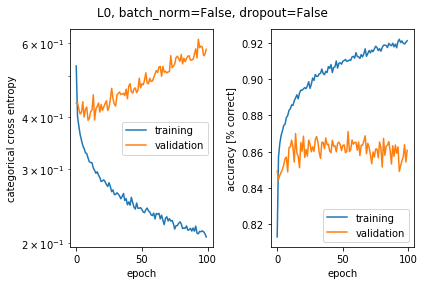

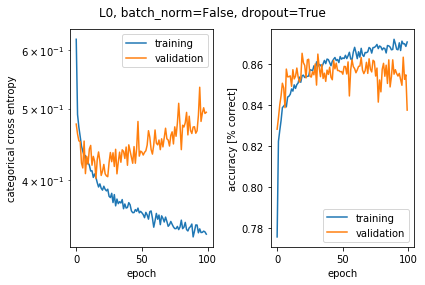

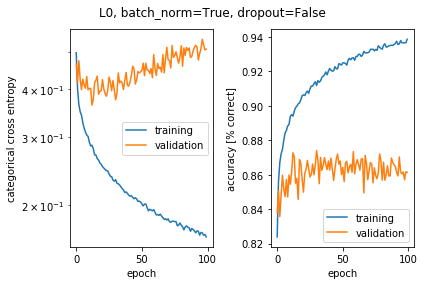

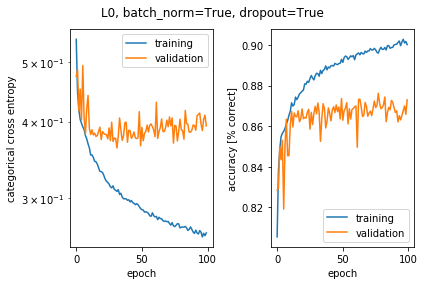

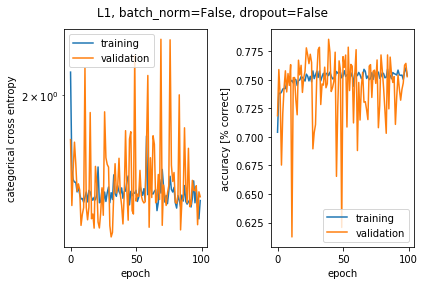

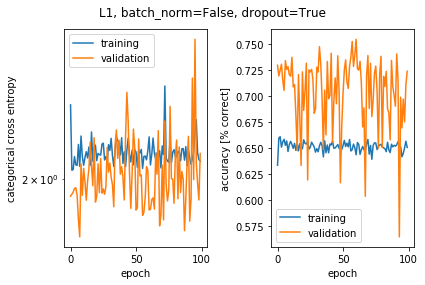

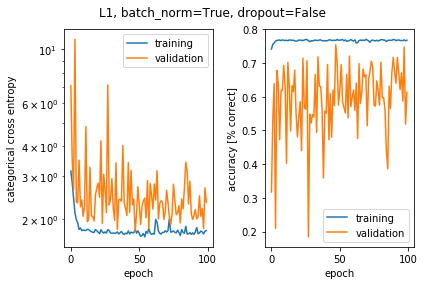

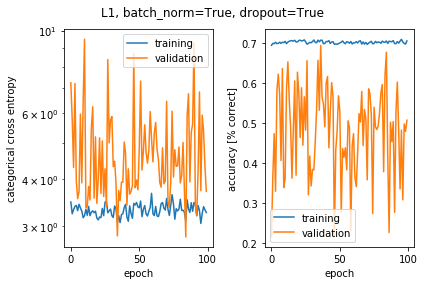

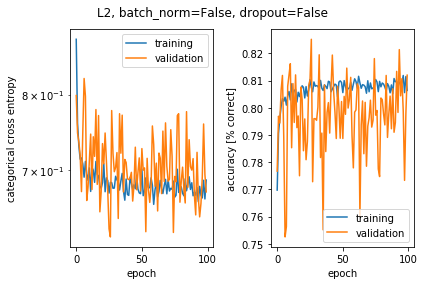

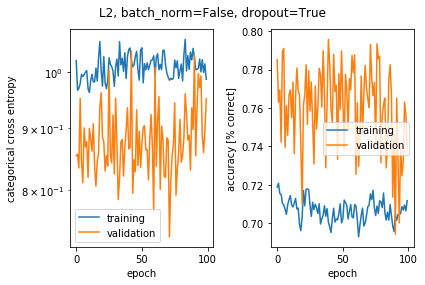

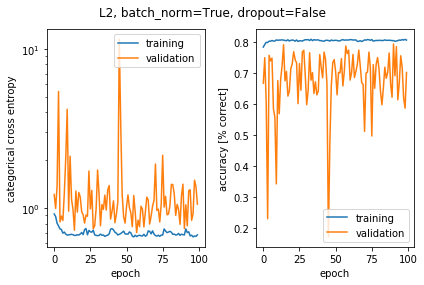

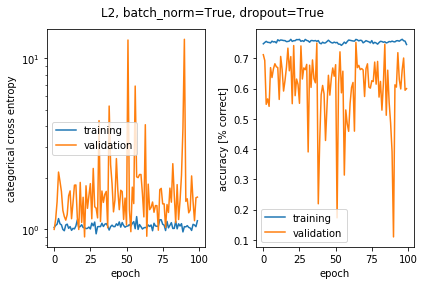

In [31]:
# Plot the learning curves of all trained models
fashion, adam = 'Fashion-MNIST', 'Adam'
for regularizer in histories_5:
    for batch_norm in histories_5[regularizer]:
        for dropout in histories_5[regularizer][batch_norm]:
            plot_history(histories_5[regularizer][batch_norm][dropout], '{}, {}, {}'.format(regularizer, batch_norm, dropout))

In [55]:
# Find best performing model based on test accuracy
best_regularizer, best_batch_norm, best_dropout = None, None, None
max_test_acc = -1
for regularizer in scores_5:
    for batch_norm in scores_5[regularizer]:
        for dropout in scores_5[regularizer][batch_norm]:
            curr_test_acc = scores_5[regularizer][batch_norm][dropout]['test_acc']
            if curr_test_acc > max_test_acc:
                max_test_acc = curr_test_acc
                best_regularizer = regularizer
                best_batch_norm = batch_norm
                best_dropout = dropout

In [56]:
# Here are some characteristics of the best performing model
best_regularizer, best_batch_norm, best_dropout

('L0', 'batch_norm=True', 'dropout=True')

In [51]:
# Fit your best performing model also to MNIST
# for having a reference for the next exercise.

# Get model
best_model = create_model_exercice5(regularizer=my_regularizers[best_regularizer], 
                               batch_norm=strtobool(best_batch_norm.split('=')[1]), 
                               dropout=strtobool(best_dropout.split('=')[1]))
# Fit model
best_history = model.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.3077 - acc: 0.9071 - val_loss: 0.1751 - val_acc: 0.9487
Epoch 2/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.1942 - acc: 0.9411 - val_loss: 0.1325 - val_acc: 0.9573
Epoch 3/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1626 - acc: 0.9500 - val_loss: 0.1217 - val_acc: 0.9634
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1484 - acc: 0.9543 - val_loss: 0.1071 - val_acc: 0.9690
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.1390 - acc: 0.9562 - val_loss: 0.1077 - val_acc: 0.9681
Epoch 6/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1277 - acc: 0.9606 - val_loss: 0.1083 - val_acc: 0.9691
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1221 - acc: 0.9610 - val_loss: 0.0998 -

60000/60000 [==============================] - 2s 36us/step - loss: 0.0553 - acc: 0.9819 - val_loss: 0.1068 - val_acc: 0.9742
Epoch 60/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0575 - acc: 0.9811 - val_loss: 0.1201 - val_acc: 0.9716
Epoch 61/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0595 - acc: 0.9798 - val_loss: 0.1125 - val_acc: 0.9731
Epoch 62/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0567 - acc: 0.9804 - val_loss: 0.1170 - val_acc: 0.9730
Epoch 63/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0567 - acc: 0.9810 - val_loss: 0.1036 - val_acc: 0.9734
Epoch 64/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0550 - acc: 0.9811 - val_loss: 0.1051 - val_acc: 0.9745
Epoch 65/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0570 - acc: 0.9805 - val_loss: 0.1033 - val_acc: 0.9742
Epoch 66/100
60000/60000 [==============

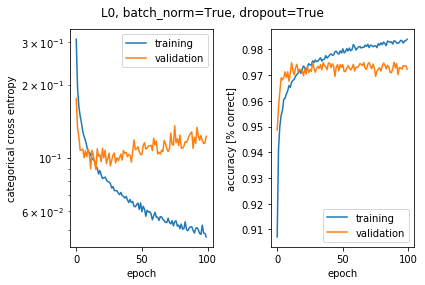

In [59]:
# Plot the resulting learning curves.
a = plot_history(best_history, '{}, {}, {}'.format(best_regularizer, best_batch_norm, best_dropout))

Answer to question 2 (comments):

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [26]:
from keras import backend as K

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape the input images to image format (adding channel dimension) and rescale the data into the range [0,1].

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

In [28]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [29]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], img_rows, img_cols, 1)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [30]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= np.max(x_train)
x_test /= np.max(x_test)

x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= np.max(x_fashion_train)
x_fashion_test /= np.max(x_fashion_test)

In [31]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples\n')

print('x_fashion_train shape:', x_fashion_train.shape)
print(x_fashion_train.shape[0], 'train fashion samples')
print(x_fashion_test.shape[0], 'test fashion samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples

x_fashion_train shape: (60000, 28, 28, 1)
60000 train fashion samples
10000 test fashion samples


In [32]:
# dropout in the hidden layers with weight constraint
def create_model_exercice6(kernel_size=(3, 3), strides=(1, 1), dropout=False, pooling=False):
    # Create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size,
                     strides=strides,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=kernel_size,
                     strides=strides,
                     activation='relu'))
    if pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [33]:
# Efficient gradient updates
batch_size = 128
# 10 digits do learn
num_classes = 10
# define number of epochs
epochs = 50

datasets = [('MNIST', x_train, x_test, y_train, y_test), 
            ('Fashion-MNIST', x_fashion_train, x_fashion_test, y_fashion_train, y_fashion_test)]


histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    # Get the model
    model = create_model_exercice6(dropout=True, pooling=True)
    # Fit the model
    history = model.fit(input_train, target_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(input_test, target_test))

    # Update histories and summaries
    histories[name], summaries[name] = history, model.summary
    # Update scores
    test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
    scores[name] = {}
    scores[name]['test_loss'] = test_loss
    scores[name]['test_acc'] = test_acc

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2768 - acc: 0.9165 - val_loss: 0.0588 - val_acc: 0.9813
Epoch 2/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0895 - acc: 0.9730 - val_loss: 0.0442 - val_acc: 0.9851
Epoch 3/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0663 - acc: 0.9806 - val_loss: 0.0331 - val_acc: 0.9879
Epoch 4/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0553 - acc: 0.9838 - val_loss: 0.0315 - val_acc: 0.9900
Epoch 5/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0467 - acc: 0.9859 - val_loss: 0.0285 - val_acc: 0.9907
Epoch 6/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0419 - acc: 0.9871 - val_loss: 0.0299 - val_acc: 0.9902
Epoch 7/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0371 - acc: 0.9889 - val_loss: 0.0286 - val_acc

Epoch 10/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1829 - acc: 0.9338 - val_loss: 0.2175 - val_acc: 0.9231
Epoch 11/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1757 - acc: 0.9365 - val_loss: 0.2193 - val_acc: 0.9216
Epoch 12/50
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1683 - acc: 0.9391 - val_loss: 0.2146 - val_acc: 0.9253
Epoch 13/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1625 - acc: 0.9421 - val_loss: 0.2082 - val_acc: 0.9293
Epoch 14/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1560 - acc: 0.9444 - val_loss: 0.2073 - val_acc: 0.9286
Epoch 15/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1487 - acc: 0.9464 - val_loss: 0.2212 - val_acc: 0.9230
Epoch 16/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1429 - acc: 0.9483 - val_loss: 0.2279 - val_acc: 0.9239
Epoch 17/50
60000/60000 [=========

In [34]:
# Save path
save_path = Path('./save/exercice6/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [60]:
# Load path
load_path = Path('./save/exercice6/')
# Load histories
histories_6 , summaries_6, scores_6 = load(load_path)

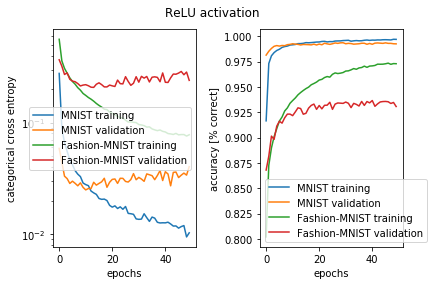

In [61]:
# Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST
mnist, fashion = 'MNIST', 'Fashion-MNIST'
a = comparison_plot(histories_6[mnist], histories_6[fashion], mnist, fashion, 'ReLU activation')        

In [78]:
# Output scores for both datasets
print('{: >13}: {}'.format(mnist, scores_6[mnist]))
print('{: >13}: {}'.format(fashion, scores_6[fashion]))


        MNIST: {'test_loss': 0.04027398465529345, 'test_acc': 0.9924}
Fashion-MNIST: {'test_loss': 0.23982352925539016, 'test_acc': 0.9306}


Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [35]:
# dropout in the hidden layers with weight constraint
def create_model_exercice7(kernel_size=(3, 3), strides=(1, 1), dropout=False, pooling=False, batch_norm=False):
    # Create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size,
                     strides=strides,
                     activation='sigmoid',
                     input_shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=kernel_size,
                     strides=strides,
                     activation='sigmoid'))
    if batch_norm:
        model.add(BatchNormalization())
    if pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [36]:
# Efficient gradient updates
batch_size = 128
# 10 digits do learn
num_classes = 10
# define number of epochs
epochs = 50

datasets = [('MNIST', x_train, x_test, y_train, y_test), 
            ('Fashion-MNIST', x_fashion_train, x_fashion_test, y_fashion_train, y_fashion_test)]
batch_norm = [False, True]

histories, summaries, scores = {}, {}, {}
for name, input_train, input_test, target_train, target_test in datasets:
    histories[name], summaries[name], scores[name] = {}, {}, {}
    for bool_ in batch_norm:       
        # Get the model
        model = create_model_exercice7(dropout=True, pooling=True, batch_norm=bool_)
        # Fit the model
        history = model.fit(input_train, target_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(input_test, target_test))

        key_bn = 'batch_norm={}'.format(str(bool_))
        histories[name][key_bn], summaries[name][key_bn] = history, model.summary       
        # Update scores
        test_loss, test_acc = model.evaluate(input_test, target_test, verbose=0)
        scores[name][key_bn] = {}
        scores[name][key_bn]['test_loss'] = test_loss
        scores[name][key_bn]['test_acc'] = test_acc

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 64s 1ms/step - loss: 2.3158 - acc: 0.1085 - val_loss: 2.3013 - val_acc: 0.1135
Epoch 2/50
60000/60000 [==============================] - 63s 1ms/step - loss: 2.3016 - acc: 0.1122 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 3/50
60000/60000 [==============================] - 63s 1ms/step - loss: 2.0290 - acc: 0.2341 - val_loss: 0.5060 - val_acc: 0.8531
Epoch 4/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.4095 - acc: 0.8774 - val_loss: 0.2380 - val_acc: 0.9298
Epoch 5/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2949 - acc: 0.9127 - val_loss: 0.1831 - val_acc: 0.9432
Epoch 6/50
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2476 - acc: 0.9273 - val_loss: 0.1596 - val_acc: 0.9533
Epoch 7/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2201 - acc: 0.9361 - val_loss: 0.1437 - val_acc

Epoch 10/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0275 - acc: 0.9914 - val_loss: 0.0322 - val_acc: 0.9908
Epoch 11/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0248 - acc: 0.9928 - val_loss: 0.0345 - val_acc: 0.9897
Epoch 12/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0206 - acc: 0.9931 - val_loss: 0.0371 - val_acc: 0.9898
Epoch 13/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0213 - acc: 0.9932 - val_loss: 0.0350 - val_acc: 0.9899
Epoch 14/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0390 - val_acc: 0.9895
Epoch 15/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0362 - val_acc: 0.9901
Epoch 16/50
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0156 - acc: 0.9949 - val_loss: 0.0381 - val_acc: 0.9891
Epoch 17/50
60000/60000 [==

Epoch 19/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3482 - acc: 0.8735 - val_loss: 0.3515 - val_acc: 0.8688
Epoch 20/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3400 - acc: 0.8771 - val_loss: 0.3241 - val_acc: 0.8846
Epoch 21/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3387 - acc: 0.8762 - val_loss: 0.3221 - val_acc: 0.8844
Epoch 22/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3348 - acc: 0.8795 - val_loss: 0.3146 - val_acc: 0.8879
Epoch 23/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3253 - acc: 0.8811 - val_loss: 0.3104 - val_acc: 0.8875
Epoch 24/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3215 - acc: 0.8834 - val_loss: 0.3090 - val_acc: 0.8885
Epoch 25/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.3158 - acc: 0.8862 - val_loss: 0.3158 - val_acc: 0.8886
Epoch 26/50
60000/60000 [=========

Epoch 28/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.1064 - acc: 0.9610 - val_loss: 0.2387 - val_acc: 0.9283
Epoch 29/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.1023 - acc: 0.9636 - val_loss: 0.2573 - val_acc: 0.9204
Epoch 30/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0993 - acc: 0.9643 - val_loss: 0.2453 - val_acc: 0.9251
Epoch 31/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0993 - acc: 0.9646 - val_loss: 0.2446 - val_acc: 0.9250
Epoch 32/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0946 - acc: 0.9664 - val_loss: 0.2567 - val_acc: 0.9257
Epoch 33/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0928 - acc: 0.9666 - val_loss: 0.2547 - val_acc: 0.9277
Epoch 34/50
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0897 - acc: 0.9673 - val_loss: 0.2564 - val_acc: 0.9254
Epoch 35/50
60000/60000 [==

In [37]:
# Save path
save_path = Path('./save/exercice7/')
# save Dictionaries
assert save(save_path, histories, summaries, scores)

In [62]:
# Load path
load_path = Path('./save/exercice7/')
# Load histories
histories_7 , summaries_7, scores_7 = load(load_path)

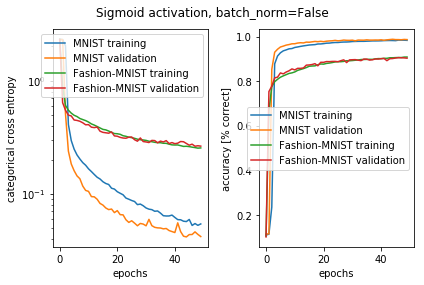

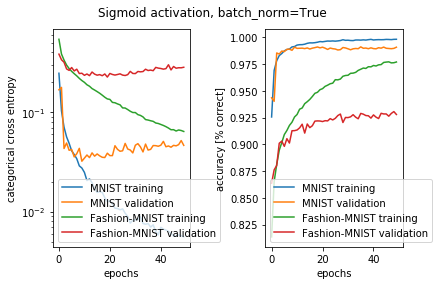

In [67]:
# Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST
mnist, fashion = 'MNIST', 'Fashion-MNIST'
for batch_norm in histories_7[mnist].keys():
    a = comparison_plot(histories_7[mnist][batch_norm], histories_7[fashion][batch_norm], mnist, fashion, 'Sigmoid activation, {}'.format(batch_norm))        

In [108]:
# Output scores for both datasets
reform = {(outerKey, middleKey): values for outerKey, middleDict in scores_7.items() for middleKey, values in middleDict.items()}
a = pd.DataFrame.from_dict(reform)
a


MNIST                    Fashion-MNIST                
          batch_norm=False batch_norm=True batch_norm=False batch_norm=True
test_acc            0.9866        0.990800          0.90310        0.927900
test_loss           0.0418        0.046439          0.26321        0.283106

In [ ]:
print('{: >16}: {: >16}'.format(mnist, scores_7[mnist]))
print('{: >16}: {: >16}'.format(fashion, scores_7[fashion]))

In [ ]:
# Output scores 
for batch_norm in histories_7[mnist].keys():
            

Answer to question 1:

Answer to question 2: